# Histogramas de altura (HAG) — cidade inteira

Este notebook lê um raster HAG (2017/2020/2024) e calcula histogramas em **streaming** (por blocos),
permitindo explorar a distribuição de alturas e fazer *zoom* nas faixas úteis para inferir pé-direito.

## O que ele gera
- Histograma **global** (por padrão 0–200 m, bins de 1,0 m)
- Histograma **zoom** (por padrão 0–40 m, bins de 0,20 m)
- Gráficos com eixo Y linear e log
- CSVs com as contagens dos histogramas


In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import pandas as pd

print('OK')


OK


## 1) Parâmetros

Ajuste apenas `RASTER_PATH` (e, se quiser, `YEAR`). O resto já vem com defaults defensáveis.

**Dica:** use `BUILDING_MIN_H = 2.0` para filtrar pixels não-construídos (ou vegetação baixa/ruído),
como você já vem fazendo no pipeline.


In [2]:
# ------------------------------------------------------------------
# AJUSTE AQUI
# ------------------------------------------------------------------
YEAR = 2017  # 2017 | 2020 | 2024 (apenas para nomear outputs)
RASTER_PATH = Path('../data/city_mosaics/hag_2017_mosaic_nodata.tif')  # <-- ajuste

# ------------------------------------------------------------------
# FILTROS
# ------------------------------------------------------------------
BUILDING_MIN_H = 2.0  # m: filtra pixels "construídos" (HAG > 2m)

# ------------------------------------------------------------------
# HISTOGRAMA GLOBAL (exploratório)
# ------------------------------------------------------------------
GLOBAL_MIN = 0.0
GLOBAL_MAX = 200.0
GLOBAL_BINWIDTH = 1.0

# ------------------------------------------------------------------
# HISTOGRAMA ZOOM (inferência de pé-direito)
# ------------------------------------------------------------------
ZOOM_MIN = 1.5
ZOOM_MAX = 28.00
ZOOM_BINWIDTH = 0.20

# ------------------------------------------------------------------
# OUTPUTS
# ------------------------------------------------------------------
OUT_DIR = Path('outputs_histogramas')
OUT_DIR.mkdir(parents=True, exist_ok=True)

print('Raster:', RASTER_PATH)
print('Outputs em:', OUT_DIR.resolve())


Raster: ../data/city_mosaics/hag_2017_mosaic_nodata.tif
Outputs em: /Users/fernandogomes/MacLab/mhac/notebooks/outputs_histogramas


## 2) Funções auxiliares (streaming por blocos)

Isso evita estourar RAM: lê cada janela do raster, aplica máscara (nodata + filtro de altura) e acumula as contagens.


In [3]:
def make_edges(vmin: float, vmax: float, binwidth: float) -> np.ndarray:
    if binwidth <= 0:
        raise ValueError('binwidth deve ser > 0')
    # garante que inclui vmax no último bin
    n_bins = int(np.ceil((vmax - vmin) / binwidth))
    edges = vmin + np.arange(n_bins + 1) * binwidth
    return edges


def streaming_histogram(
    src: rasterio.io.DatasetReader,
    edges: np.ndarray,
    building_min_h: float | None = None,
) -> tuple[np.ndarray, dict]:
    """Acumula histograma por blocos do raster.

    Retorna (counts, meta) onde meta inclui contagens de pixels válidos e filtrados.
    """
    counts = np.zeros(len(edges) - 1, dtype=np.int64)
    total_pixels = 0
    valid_pixels = 0
    used_pixels = 0

    nodata = src.nodata

    for _, window in src.block_windows(1):
        arr = src.read(1, window=window)
        total_pixels += arr.size

        mask = np.isfinite(arr)
        if nodata is not None:
            mask &= (arr != nodata)
        valid = arr[mask]
        valid_pixels += valid.size

        if building_min_h is not None:
            valid = valid[valid > building_min_h]

        used_pixels += valid.size
        if valid.size:
            # numpy.histogram já ignora valores fora da faixa via bins
            c, _ = np.histogram(valid, bins=edges)
            counts += c

    meta = {
        'nodata': nodata,
        'total_pixels': int(total_pixels),
        'valid_pixels': int(valid_pixels),
        'used_pixels': int(used_pixels),
    }
    return counts, meta


## 3) Rodar os histogramas


In [4]:
global_edges = make_edges(GLOBAL_MIN, GLOBAL_MAX, GLOBAL_BINWIDTH)
zoom_edges = make_edges(ZOOM_MIN, ZOOM_MAX, ZOOM_BINWIDTH)

with rasterio.open(RASTER_PATH) as src:
    print('CRS:', src.crs)
    print('Shape:', (src.height, src.width))
    print('Nodata:', src.nodata)
    
    global_counts, global_meta = streaming_histogram(src, global_edges, BUILDING_MIN_H)
    zoom_counts, zoom_meta = streaming_histogram(src, zoom_edges, BUILDING_MIN_H)

global_meta, zoom_meta


CRS: EPSG:31983
Shape: (72953, 47505)
Nodata: -9999.0


({'nodata': -9999.0,
  'total_pixels': 3465632265,
  'valid_pixels': 1424345756,
  'used_pixels': 482183862},
 {'nodata': -9999.0,
  'total_pixels': 3465632265,
  'valid_pixels': 1424345756,
  'used_pixels': 482183862})

## 4) Salvar CSVs


In [5]:
def to_df(edges: np.ndarray, counts: np.ndarray) -> pd.DataFrame:
    left = edges[:-1]
    right = edges[1:]
    center = (left + right) / 2
    return pd.DataFrame({
        'bin_left_m': left,
        'bin_right_m': right,
        'bin_center_m': center,
        'count': counts,
    })

df_global = to_df(global_edges, global_counts)
df_zoom = to_df(zoom_edges, zoom_counts)

global_csv = OUT_DIR / f'hist_global_{YEAR}_{GLOBAL_MIN:g}_{GLOBAL_MAX:g}_bw{GLOBAL_BINWIDTH:g}.csv'
zoom_csv = OUT_DIR / f'hist_zoom_{YEAR}_{ZOOM_MIN:g}_{ZOOM_MAX:g}_bw{ZOOM_BINWIDTH:g}.csv'

df_global.to_csv(global_csv, index=False)
df_zoom.to_csv(zoom_csv, index=False)

global_csv, zoom_csv


(PosixPath('outputs_histogramas/hist_global_2017_0_200_bw1.csv'),
 PosixPath('outputs_histogramas/hist_zoom_2017_1.5_28_bw0.2.csv'))

## 5) Plotar

Inclui versões com eixo Y linear e log (log ajuda a ver a cauda).

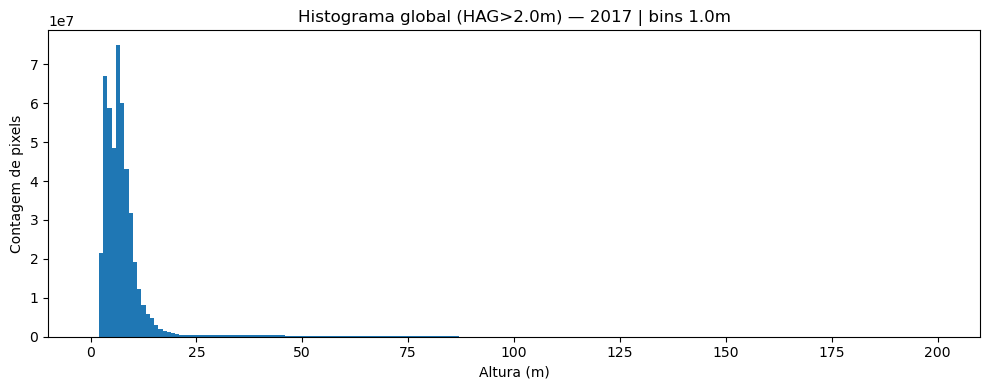

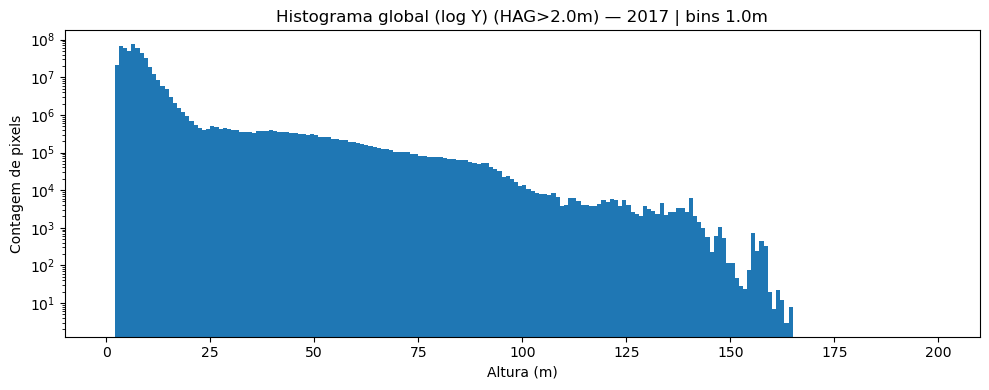

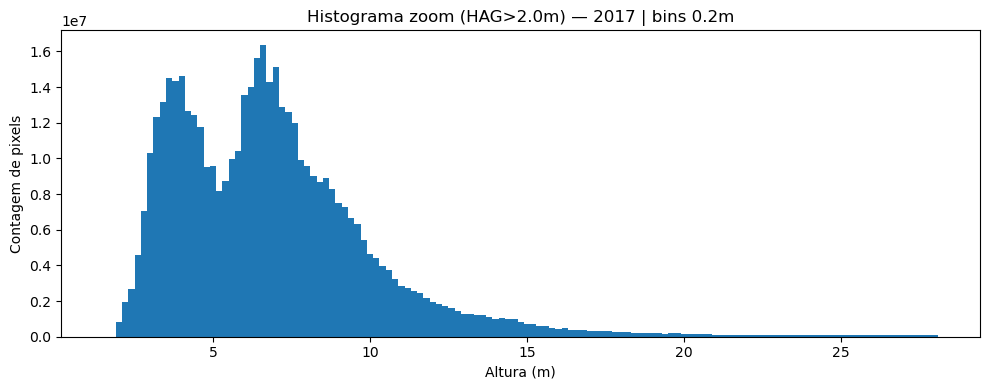

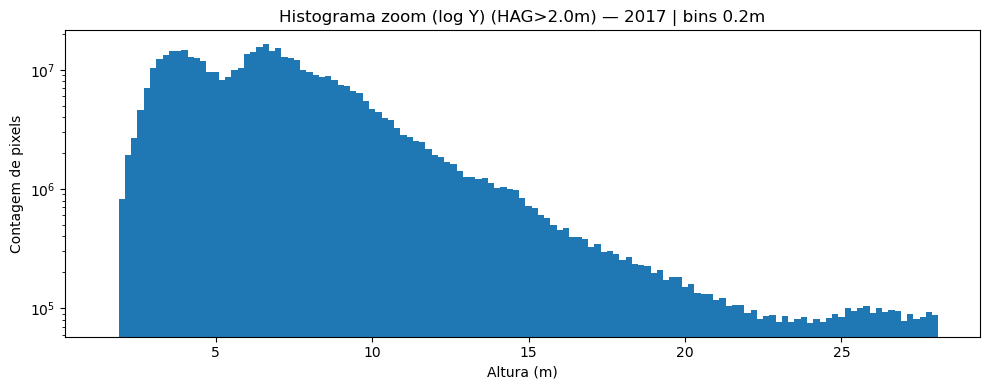

In [6]:
def plot_hist(df: pd.DataFrame, title: str, ylog: bool = False):
    plt.figure(figsize=(10, 4))
    plt.bar(df['bin_center_m'], df['count'], width=(df['bin_right_m'] - df['bin_left_m']).iloc[0])
    plt.xlabel('Altura (m)')
    plt.ylabel('Contagem de pixels')
    if ylog:
        plt.yscale('log')
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_hist(df_global, f'Histograma global (HAG>{BUILDING_MIN_H}m) — {YEAR} | bins {GLOBAL_BINWIDTH}m', ylog=False)
plot_hist(df_global, f'Histograma global (log Y) (HAG>{BUILDING_MIN_H}m) — {YEAR} | bins {GLOBAL_BINWIDTH}m', ylog=True)
plot_hist(df_zoom, f'Histograma zoom (HAG>{BUILDING_MIN_H}m) — {YEAR} | bins {ZOOM_BINWIDTH}m', ylog=False)
plot_hist(df_zoom, f'Histograma zoom (log Y) (HAG>{BUILDING_MIN_H}m) — {YEAR} | bins {ZOOM_BINWIDTH}m', ylog=True)


In [16]:
def plot_hist(
    df: pd.DataFrame,
    title: str,
    ylog: bool = False,
    hp: float = 3.4,
    show_pavement_bands: bool = True,
    show_empirical_peaks: bool = True,
):
    fig, ax = plt.subplots(figsize=(10, 4))

    bin_width = (df['bin_right_m'] - df['bin_left_m']).iloc[0]

    ax.bar(
        df['bin_center_m'],
        df['count'],
        width=bin_width,
        color='#1f77b4',
        alpha=0.9
    )

    ax.set_xlabel('Altura (m)')
    ax.set_ylabel('Contagem de pixels')

    if ylog:
        ax.set_yscale('log')

    # -------------------------------------------------
    # Linha do parâmetro adotado (3.4 m)
    # -------------------------------------------------
    ax.axvline(
        hp,
        color='black',
        linewidth=2,
        label=f'hp = {hp:.1f} m'
    )

    # -------------------------------------------------
    # Limiares de arredondamento (hp + hp/2, hp*2 + hp/2, ...)
    # -------------------------------------------------
    threshold_1 = hp * 1.5      # ~5.1 m
    threshold_2 = hp * 2.5      # ~8.5 m

    ax.axvline(threshold_1, color='black', linestyle='--', linewidth=1)
    ax.axvline(threshold_2, color='black', linestyle='--', linewidth=1)

    # -------------------------------------------------
    # Faixas de pavimentos (opcional)
    # -------------------------------------------------
    if show_pavement_bands:
        ax.axvspan(0, threshold_1, color='green', alpha=0.08, label='1 pavimento')
        ax.axvspan(threshold_1, threshold_2, color='orange', alpha=0.08, label='2 pavimentos')
        ax.axvspan(threshold_2, threshold_2 + hp, color='red', alpha=0.06, label='3 pavimentos')

    # -------------------------------------------------
    # Picos empíricos observados (opcional)
    # -------------------------------------------------
    if show_empirical_peaks:
        ax.axvline(3.8, color='red', linestyle=':', linewidth=1)
        ax.axvline(6.6, color='red', linestyle=':', linewidth=1)

    ax.set_title(title)
    ax.legend(loc='upper right', frameon=False)
    plt.tight_layout()
    plt.show()


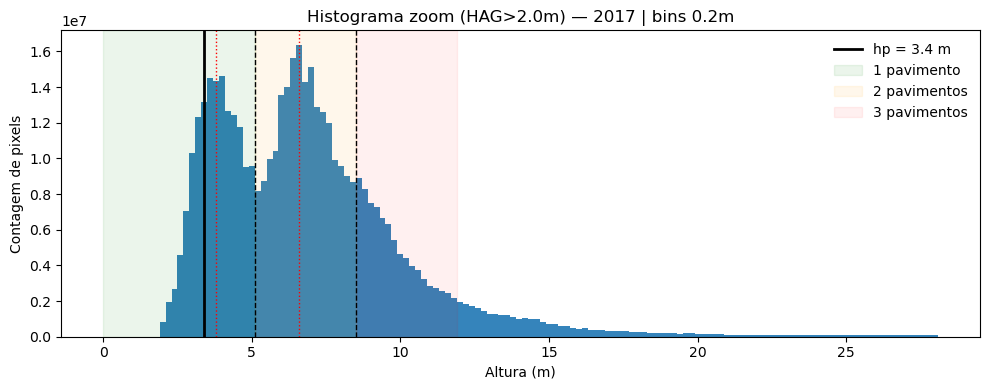

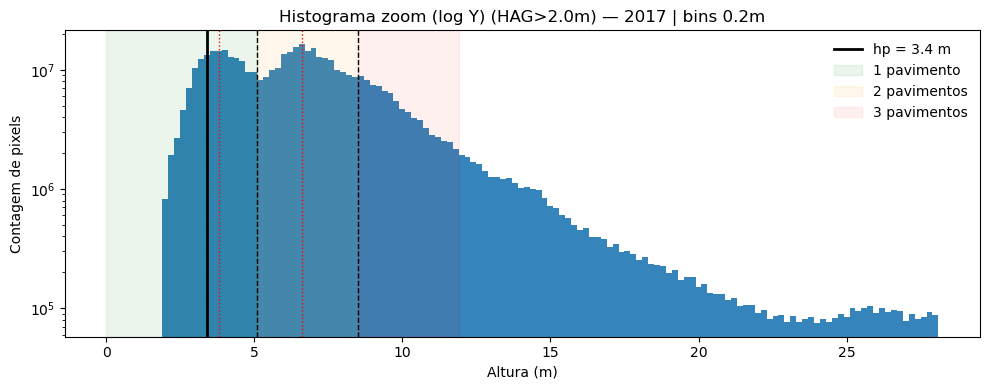

In [17]:
plot_hist(
    df_zoom,
    f'Histograma zoom (HAG>{BUILDING_MIN_H}m) — {YEAR} | bins {ZOOM_BINWIDTH}m',
    ylog=False
)

plot_hist(
    df_zoom,
    f'Histograma zoom (log Y) (HAG>{BUILDING_MIN_H}m) — {YEAR} | bins {ZOOM_BINWIDTH}m',
    ylog=True
)


## 6) (Opcional) Sensibilidade: 0,10 m no zoom

Roda uma segunda versão do zoom para verificar estabilidade dos picos.


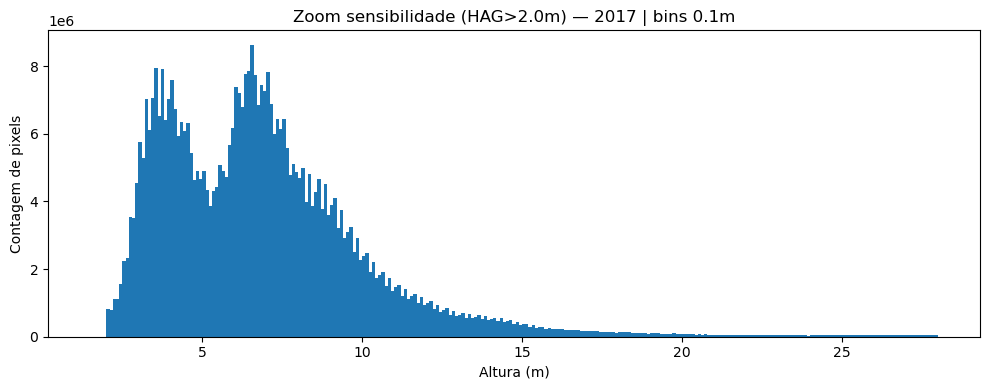

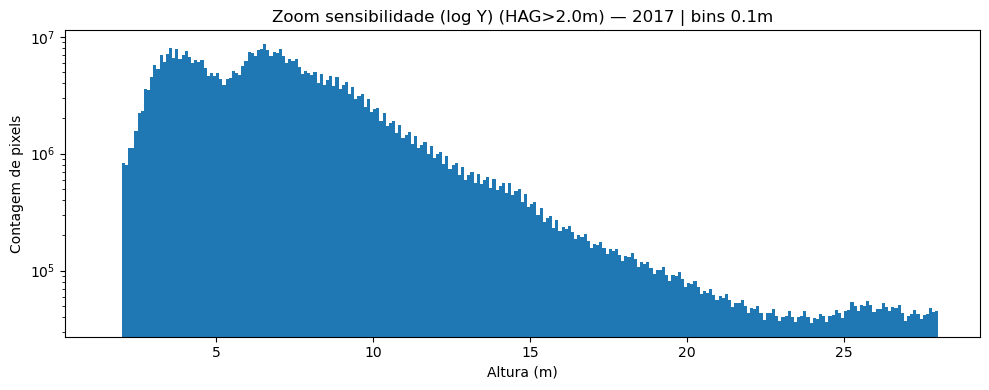

PosixPath('outputs_histogramas/hist_zoom_2017_1.5_28_bw0.1.csv')

In [7]:
ZOOM_BINWIDTH_SENS = 0.10
zoom_edges_sens = make_edges(ZOOM_MIN, ZOOM_MAX, ZOOM_BINWIDTH_SENS)

with rasterio.open(RASTER_PATH) as src:
    zoom_counts_sens, _ = streaming_histogram(src, zoom_edges_sens, BUILDING_MIN_H)

df_zoom_sens = to_df(zoom_edges_sens, zoom_counts_sens)
zoom_csv_sens = OUT_DIR / f'hist_zoom_{YEAR}_{ZOOM_MIN:g}_{ZOOM_MAX:g}_bw{ZOOM_BINWIDTH_SENS:g}.csv'
df_zoom_sens.to_csv(zoom_csv_sens, index=False)

plot_hist(df_zoom_sens, f'Zoom sensibilidade (HAG>{BUILDING_MIN_H}m) — {YEAR} | bins {ZOOM_BINWIDTH_SENS}m', ylog=False)
plot_hist(df_zoom_sens, f'Zoom sensibilidade (log Y) (HAG>{BUILDING_MIN_H}m) — {YEAR} | bins {ZOOM_BINWIDTH_SENS}m', ylog=True)

zoom_csv_sens


## 7) Notas rápidas (pra você colar no método)

- O histograma global (bins 1 m) serve para identificar regimes de altura e escolher *zooms*.
- O zoom (bins 0,20 m e 0,10 m) é calibrado para resolver a periodicidade entre pavimentos.
- Trabalhar em streaming evita carregar o mosaico inteiro em RAM.
